<a href="https://colab.research.google.com/github/Ruby-L-i-n/CSDS234_FinalProject/blob/main/SpotifyPlaylist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imported APIs
import numpy as np
import pandas as pd
import heapq
import random
import json
import matplotlib.pyplot as pyplot
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training Data

## Pre-Processing and Formatting JSON Files

In [3]:
#Here we are only using 800 playlists from the first file of playlists because of hardware limitations
np.random.seed(seed = 19) #a random seed to ensure calculation is the same across methods. if you want to generate a different set of random numbers, enter a new seed
numbers = np.arange(0,1000,1) #a range of numbers from 1 to 1000
sample = np.random.choice(numbers, size=800, replace=False) #an array storing the pids of the 800 random playlists

In [4]:
with open("/content/drive/Shareddrives/CSDS 234 Final Project/spotify_million_playlist_dataset/data/mpd.slice.0-999.json") as f:
    data = json.load(f)

flattened_playlists = []
for playlist in data['playlists']:
    playlist_info = {
        'pid': playlist['pid'],
        'name': playlist.get('name', None),
        'collaborative': playlist['collaborative'],
        'modified_at': playlist['modified_at'],
        'num_tracks': playlist['num_tracks'],
        'num_albums': playlist['num_albums'],
        'num_followers': playlist['num_followers']
    }

    for track in playlist['tracks']:
        track_info = {
            'playlist_pid': playlist['pid'],
            'track_pos': track['pos'],
            'track_name': track['track_name'],
            'track_uri': track['track_uri'],
            'artist_name': track['artist_name'],
            'artist_uri': track['artist_uri'],
            'album_name': track['album_name'],
            'album_uri': track['album_uri'],
            'duration_ms': track['duration_ms']
        }
        flattened_playlists.append({**playlist_info, **track_info})

# Create a Pandas DataFrame for our schema
df = pd.DataFrame(flattened_playlists)

#View the first 10 tuples of our schema with 1000 playlists
df.head(10)

,pid,name,collaborative,modified_at,num_tracks,num_albums,num_followers,playlist_pid,track_pos,track_name,track_uri,artist_name,artist_uri,album_name,album_uri,duration_ms
0,0,Throwbacks,false,1493424000,52,47,1,0,0,Lose Control (feat. Ciara & Fat Man Scoop),spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863
1,0,Throwbacks,false,1493424000,52,47,1,0,1,Toxic,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800
2,0,Throwbacks,false,1493424000,52,47,1,0,2,Crazy In Love,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933
3,0,Throwbacks,false,1493424000,52,47,1,0,3,Rock Your Body,spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266
4,0,Throwbacks,false,1493424000,52,47,1,0,4,It Wasn't Me,spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600
5,0,Throwbacks,false,1493424000,52,47,1,0,5,Yeah!,spotify:track:0XUfyU2QviPAs6bxSpXYG4,Usher,spotify:artist:23zg3TcAtWQy7J6upgbUnj,Confessions,spotify:album:0vO0b1AvY49CPQyVisJLj0,250373
6,0,Throwbacks,false,1493424000,52,47,1,0,6,My Boo,spotify:track:68vgtRHr7iZHpzGpon6Jlo,Usher,spotify:artist:23zg3TcAtWQy7J6upgbUnj,Confessions,spotify:album:1RM6MGv6bcl6NrAG8PGoZk,223440
7,0,Throwbacks,false,1493424000,52,47,1,0,7,Buttons,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,The Pussycat Dolls,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,PCD,spotify:album:5x8e8UcCeOgrOzSnDGuPye,225560
8,0,Throwbacks,false,1493424000,52,47,1,0,8,Say My Name,spotify:track:7H6ev70Weq6DdpZyyTmUXk,Destiny's Child,spotify:artist:1Y8cdNmUJH7yBTd9yOvr5i,The Writing's On The Wall,spotify:album:283NWqNsCA9GwVHrJk59CG,271333
9,0,Throwbacks,false,1493424000,52,47,1,0,9,Hey Ya! - Radio Mix / Club Mix,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,OutKast,spotify:artist:1G9G7WwrXka3Z1r7aIDjI7,Speakerboxxx/The Love Below,spotify:album:1UsmQ3bpJTyK6ygoOOjG1r,235213


In [5]:
#Clean the data by only selecting the 800 random playlists
clean_df = df.loc[df["pid"].isin(sample)]
del(df, numbers)
clean_df.head()

,pid,name,collaborative,modified_at,num_tracks,num_albums,num_followers,playlist_pid,track_pos,track_name,track_uri,artist_name,artist_uri,album_name,album_uri,duration_ms
52,1,Awesome Playlist,false,1506556800,39,23,1,1,0,Eye of the Tiger,spotify:track:2HHtWyy5CgaQbC7XSoOb0e,Survivor,spotify:artist:26bcq2nyj5GB7uRr558iQg,Eye Of The Tiger,spotify:album:4PT9VulQaQP6XR1xBI2x1W,243773
53,1,Awesome Playlist,false,1506556800,39,23,1,1,1,Libera Me From Hell (Tengen Toppa Gurren Lagann),spotify:track:1MYYt7h6amcrauCOoso3Gx,Daniel Tidwell,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,Versus Hollywood,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,70294
54,1,Awesome Playlist,false,1506556800,39,23,1,1,2,Pokémon Theme,spotify:track:3x2mJ2bjCIU70NrH49CtYR,Daniel Tidwell,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,Versus Hollywood,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,65306
55,1,Awesome Playlist,false,1506556800,39,23,1,1,3,Concerning Hobbits (The Lord of the Rings),spotify:track:1Pm3fq1SC6lUlNVBGZi3Em,Daniel Tidwell,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,Versus Hollywood,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,108532
56,1,Awesome Playlist,false,1506556800,39,23,1,1,4,The Blood of Cuchulainn (The Boondock Saints),spotify:track:1NXTEkIeRL59NK61QuhYUl,Daniel Tidwell,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,Versus Hollywood,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,214268


Before we start it is useful to gain some insights on the data we are working with.

In [6]:
print("total number of songs: ", len(set(clean_df["track_name"])))
print("total number of playlists: ", len(set(clean_df["pid"])))
print("average number of songs in a playlist: ", sum(clean_df['pid'].value_counts()/800))

total number of songs:  25551
total number of playlists:  800
average number of songs in a playlist:  67.54125000000006


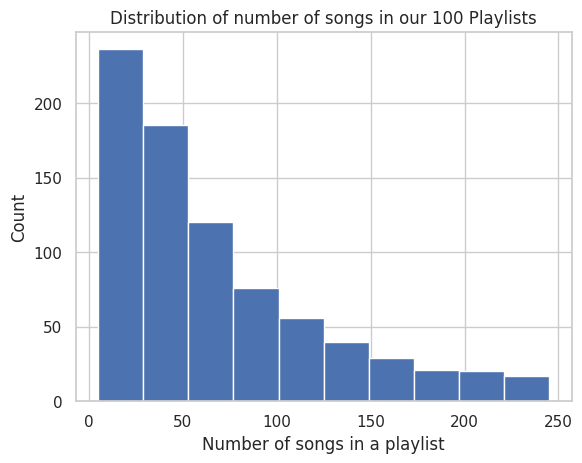

In [7]:
pyplot.hist(clean_df['pid'].value_counts())
pyplot.title("Distribution of number of songs in our 100 Playlists")
pyplot.ylabel("Count")
pyplot.xlabel("Number of songs in a playlist")
pyplot.show()

Text(0.5, 0, 'Total songs across playlists')

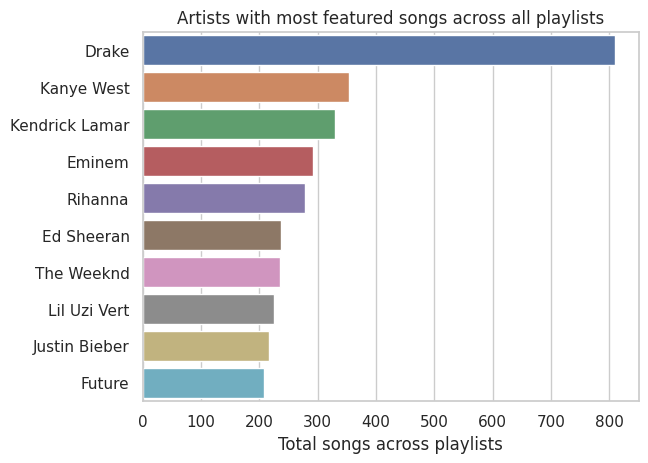

In [8]:
# Checking which artists are featured most across all playlists
values = list(clean_df['artist_name'].value_counts())
names = clean_df['artist_name'].value_counts().index.tolist()

ax = sns.barplot(y=names[0:10], x=values[0:10])
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

# Test Data

## Cleaning and Preprocessing

In [9]:
#Randomly select a different JSON file with new playlist data to avoid selecting playlists from our training playlists

file_name_list = ['1000-1999', '2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999', '8000-8999', '9000-9999']
np.random.seed(seed=18)
selected_file = np.random.choice(file_name_list)

with open("/content/drive/Shareddrives/CSDS 234 Final Project/spotify_million_playlist_dataset/data/mpd.slice."+ selected_file + ".json") as g:
    data = json.load(g)

    test_playlists = []
for playlist in data['playlists']:
    playlist_info = {
        'pid': playlist['pid'],
        'name': playlist.get('name', None),
        'collaborative': playlist['collaborative'],
        'modified_at': playlist['modified_at'],
        'num_tracks': playlist['num_tracks'],
        'num_albums': playlist['num_albums'],
        'num_followers': playlist['num_followers']
    }

    for track in playlist['tracks']:
        track_info = {
            #'playlist_pid': playlist['pid'], # is this a redudant variable?
            'track_pos': track['pos'],
            'track_name': track['track_name'],
            'track_uri': track['track_uri'],
            'artist_name': track['artist_name'],
            'artist_uri': track['artist_uri'],
            'album_name': track['album_name'],
            'album_uri': track['album_uri'],
            'duration_ms': track['duration_ms']
        }
        test_playlists.append({**playlist_info, **track_info})

# Create a Pandas DataFrame to store the test playlists
test1000_df = pd.DataFrame(test_playlists)
test1000_df.head(10)

,pid,name,collaborative,modified_at,num_tracks,num_albums,num_followers,track_pos,track_name,track_uri,artist_name,artist_uri,album_name,album_uri,duration_ms
0,4000,skate,true,1432252800,70,62,1,0,Circles,spotify:track:53yXbISmPFewWiFP2kgal8,Ty Segall,spotify:artist:58XGUNsRNu3cVOIOYk5chx,Mr. Face,spotify:album:5bXUYhd6yvmry49a8WpEqS,186176
1,4000,skate,true,1432252800,70,62,1,1,Ramble Tamble,spotify:track:47atuTch0AN7NvP9vp42a5,Creedence Clearwater Revival,spotify:artist:3IYUhFvPQItj6xySrBmZkd,Cosmo's Factory,spotify:album:4GLxEXWI3JiRKp6H7bfTIK,431226
2,4000,skate,true,1432252800,70,62,1,2,Brendan 1,spotify:track:7uzeJ1HasqTqqB2anNRFCs,Fugazi,spotify:artist:62sC6lUEWRjbFqXpMmOk4G,Repeater,spotify:album:3ZnF1cPxlqB48RyLiecDnv,152493
3,4000,skate,true,1432252800,70,62,1,3,Death of a Ladies' Man,spotify:track:5wrylUGwZugelovhryPYg2,Leonard Cohen,spotify:artist:5l8VQNuIg0turYE1VtM9zV,Death Of A Ladies' Man,spotify:album:0qghwsBOHAhmIukaW08IOT,564133
4,4000,skate,true,1432252800,70,62,1,4,After Laughter (Comes Tears),spotify:track:2bsAzwSesOofKlc8ip4MB7,Wendy Rene,spotify:artist:4ba7uNtpOq0us2C5Nx19zN,After Laughter Comes Tears: Complete Stax & Vo...,spotify:album:6lSJwPx7Sqdl7nGLHb3mkG,182893
5,4000,skate,true,1432252800,70,62,1,5,"How You Doin, Here We Go",spotify:track:3OWgczPOsu1xCWV5ClpV8Q,Ray Barbee Meets the Mattson 2,spotify:artist:6980BgFWNc5h3wbuhA6QTm,Ray Barbee Meet the Mattson 2,spotify:album:3RxFFFMvhjB87uLFSXzdl2,73600
6,4000,skate,true,1432252800,70,62,1,6,"Please, Please, Please - Live At The Apollo Th...",spotify:track:0HOqGdqxLZN68sdm06LDiV,James Brown & The Famous Flames,spotify:artist:32r72WOqqRO1DtSznId7Lr,'Live' At The Apollo Vol. II,spotify:album:7um5ZTFpHJQCbBdOdLbsCg,161466
7,4000,skate,true,1432252800,70,62,1,7,Wild Witch,spotify:track:5SHcOU4noUpL9OU3rnWxXl,Restavrant,spotify:artist:64Xip1q4drLaPRLqHXlzBU,"Yeah, I Carve Cheetahs",spotify:album:2CYymhzoMGZIYUrFXh0WBO,210430
8,4000,skate,true,1432252800,70,62,1,8,Gut Feeling,spotify:track:4fNbrazMYC1CbalcQ8YFGC,DEVO,spotify:artist:0UKfenbZb15sqhfPC6zbt3,The Life Aquatic With Steve Zissou,spotify:album:05mpXOy7NNlc3oGqNathD6,247160
9,4000,skate,true,1432252800,70,62,1,9,Good Morning Judge,spotify:track:0wLFcJ5jPNnpGwSdZ0JSG2,Furry Lewis,spotify:artist:66SiMdpsWXE23qqX0JaWg9,Good Morning Judge,spotify:album:4SejT5bBFYH6qC9ikemWl2,331333


In [10]:
"""
We chose playlists (pids) with greater than 100 songs so that our model has at least 30 songs to work with if we
split 70% of the playlist into training and the other 30% into testing, we'd still have about our average playlist size
of 70 songs for our model to provide 30 recommendations for.
"""
# Filter playlists with between 100 and 200 tracks
large_test_pl = test1000_df[(test1000_df['num_tracks'] >= 100) & (test1000_df['num_tracks'] <= 200)]

# Randomly select 25 unique playlist pids
selected_playlist_pids = large_test_pl['pid'].sample(n=25, random_state=18).tolist()

# Filter the DataFrame to include only rows corresponding to the selected playlist pids
test_playlists = large_test_pl[large_test_pl['pid'].isin(selected_playlist_pids)]

# Display the first 10 tuples selected playlists
print(test_playlists.head(10))

# Display the pids of the selected playlists
print(test_playlists['pid'].unique())


      pid     name collaborative  modified_at  num_tracks  num_albums  num_followers  track_pos                                    track_name                             track_uri             artist_name                             artist_uri                         album_name                             album_uri  duration_ms
647  4012  perfect         false   1508112000         147         127             17          0                                       Nevers!  spotify:track:10UPEBVvsi41UuGWvYNfxU      The Fiery Furnaces  spotify:artist:03G0pJHLHj7FRuCV5OYzpv                         Bitter Tea  spotify:album:5UoVVQjYLaaHKvmA8l1ybm       302826
648  4012  perfect         false   1508112000         147         127             17          1  Those Pockets Are People/The Partisan (Live)  spotify:track:0xEG4nlsKojgNJBAwa3CRo             Electrelane  spotify:artist:7ulIMfVKiXh8ecEpAVHIAY            Singles, B-sides & Live  spotify:album:4JKSYUOqhG7BHJN2x9z56y       482040
649  4012  pe

## Splitting the Test Data

In [11]:
"""
This is a function to split a data frame of all playlists into seperate dfs for a single playlist

Input: A large dataframe with several playlists
Output: A dictionary indexed by pid for each single playlist dataframe
"""
def split_single(df):
  playlists_dict = {}
  for pid in df['pid'].unique():
    playlist = df[df['pid'] == pid]
    playlists_dict[pid] = playlist.copy()  # Store each playlist in the dictionary

  return playlists_dict

# Splitting playlists into dataframes for each playlist
playlist_catalog = split_single(test_playlists)

print(playlist_catalog[4012])
print(playlist_catalog.keys())

      pid     name collaborative  modified_at  num_tracks  num_albums  num_followers  track_pos                                    track_name                             track_uri         artist_name                             artist_uri                 album_name                             album_uri  duration_ms
647  4012  perfect         false   1508112000         147         127             17          0                                       Nevers!  spotify:track:10UPEBVvsi41UuGWvYNfxU  The Fiery Furnaces  spotify:artist:03G0pJHLHj7FRuCV5OYzpv                 Bitter Tea  spotify:album:5UoVVQjYLaaHKvmA8l1ybm       302826
648  4012  perfect         false   1508112000         147         127             17          1  Those Pockets Are People/The Partisan (Live)  spotify:track:0xEG4nlsKojgNJBAwa3CRo         Electrelane  spotify:artist:7ulIMfVKiXh8ecEpAVHIAY    Singles, B-sides & Live  spotify:album:4JKSYUOqhG7BHJN2x9z56y       482040
649  4012  perfect         false   1508112000    

In [12]:
"""
Here we need to split our test playlists 0.7:0.3 training to test data.
We will need to select 30% of the playlist and store it for cross checking recommendations later.

Now we want to interate through each playlist df in the catalog and split them into training and test data.
We will use an imported function to make this easier/ more efficient.
"""
train_playlists_dict = {}
test_playlists_dict = {}

# Assuming playlist_catalog is a dictionary containing playlists
for key in playlist_catalog:
    playlist = playlist_catalog[key]  # Get the playlist dataframe for the current key

    # Splitting the current playlist into 70% train and 30% test
    train_playlist, test_playlist = train_test_split(playlist, test_size=0.3)

    # Storing the split playlists in separate dictionaries
    train_playlists_dict[key] = train_playlist
    test_playlists_dict[key] = test_playlist

print(train_playlists_dict[4012].shape) ## This will tell us how many songs were split from the orig playlist to the training and test dfs
print(test_playlists_dict[4012].shape)


(102, 15)
(45, 15)


## Combining the Data

In [13]:
#
def join_data(test_1_df):
  frames = [clean_df, test_1_df]
  join_df = pd.concat(frames)
  return join_df

test_1_df = test_playlists[test_playlists['pid'].isin([4012])]
join_df = join_data(test_1_df)
join_df

,pid,name,collaborative,modified_at,num_tracks,num_albums,num_followers,playlist_pid,track_pos,track_name,track_uri,artist_name,artist_uri,album_name,album_uri,duration_ms
52,1,Awesome Playlist,false,1506556800,39,23,1,1.0,0,Eye of the Tiger,spotify:track:2HHtWyy5CgaQbC7XSoOb0e,Survivor,spotify:artist:26bcq2nyj5GB7uRr558iQg,Eye Of The Tiger,spotify:album:4PT9VulQaQP6XR1xBI2x1W,243773
53,1,Awesome Playlist,false,1506556800,39,23,1,1.0,1,Libera Me From Hell (Tengen Toppa Gurren Lagann),spotify:track:1MYYt7h6amcrauCOoso3Gx,Daniel Tidwell,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,Versus Hollywood,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,70294
54,1,Awesome Playlist,false,1506556800,39,23,1,1.0,2,Pokémon Theme,spotify:track:3x2mJ2bjCIU70NrH49CtYR,Daniel Tidwell,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,Versus Hollywood,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,65306
55,1,Awesome Playlist,false,1506556800,39,23,1,1.0,3,Concerning Hobbits (The Lord of the Rings),spotify:track:1Pm3fq1SC6lUlNVBGZi3Em,Daniel Tidwell,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,Versus Hollywood,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,108532
56,1,Awesome Playlist,false,1506556800,39,23,1,1.0,4,The Blood of Cuchulainn (The Boondock Saints),spotify:track:1NXTEkIeRL59NK61QuhYUl,Daniel Tidwell,spotify:artist:7zdmbPudNX4SQJXnYIuCTC,Versus Hollywood,spotify:album:3q8vR3PFV8kG1m1Iv8DpKq,214268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,4012,perfect,false,1508112000,147,127,17,NaN,142,Two Of Us,spotify:track:6U9MSE8pPccBnCd0zA2oSw,Paulinho Garcia,spotify:artist:43Q9oS0K3TSjq7fU3yi4rD,The Beatles Nova,spotify:album:1esKHENSStKBUuuh53xxug,202973
790,4012,perfect,false,1508112000,147,127,17,NaN,143,Farewell Transmission,spotify:track:4fkAWGCbxNizyNwsHlrajH,Songs: Ohia,spotify:artist:3uQ5cxFHxXddqPL58egs1z,Magnolia Electric Co.,spotify:album:41RHNc47RzqBt9FBmhb8YY,442106
791,4012,perfect,false,1508112000,147,127,17,NaN,144,"Fare Thee Well, Miss Carousel",spotify:track:1Mk5KFw0z8wZHI1k1NkVkP,Townes Van Zandt,spotify:artist:3ZWab2LEVkNKiBPIClTwof,Townes Van Zandt,spotify:album:1ntCjvLawrpEg3UmMymC0b,322586
792,4012,perfect,false,1508112000,147,127,17,NaN,145,Our Mother The Mountain,spotify:track:2eHHDSLaveJcvpWyeNPPE7,Townes Van Zandt,spotify:artist:3ZWab2LEVkNKiBPIClTwof,Our Mother The Mountain,spotify:album:1ecPXtzlzesTS7l8HmmVyc,262306


# Creating the sparse matrix

In [14]:
#create a sparse matrix of song in playlist as a dataframe
from scipy import sparse

def Sparse_Matrix(matrix_df):
  pl_song_df = pd.crosstab(index=matrix_df['pid'], columns=matrix_df['track_name'])
  pl_song_matrix = sparse.csr_matrix(pl_song_df)
  return pl_song_matrix

pl_song_matrix = Sparse_Matrix(join_df)

# K-Nearest Neighbor (KNN) Model

In [20]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(pl_song_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [22]:
distances, indices = model_knn.kneighbors(pl_song_matrix[800], n_neighbors=50)
distances, indices

# After this command the indices do not correspond with the original pids

(array([[0.        , 0.96103814, 0.96213588, 0.96437459, 0.97322602,
         0.97550204, 0.9787222 , 0.97926097, 0.98051907, 0.98106794,
         0.98247232, 0.98287531, 0.98287531, 0.98287531, 0.98325172,
         0.98424757, 0.98461311, 0.98521153, 0.98533529, 0.9862249 ,
         0.98642312, 0.98697006, 0.9871382 , 0.98729999, 0.98749389,
         0.98760606, 0.98789101, 0.98815718, 0.98828384, 0.98840653,
         0.98852544, 0.98852544, 0.98852544, 0.98864076, 0.98899286,
         0.98906957, 0.98916939, 0.98916939, 0.9893611 , 0.98954298,
         0.98954298, 0.98988039, 0.99003729, 0.99003729, 0.99011305,
         0.99033038, 0.99039969, 0.99046754, 0.99078644, 0.99107534]]),
 array([[800, 677, 334, 534,  30, 705, 166, 391, 797, 148, 540, 101, 198,
         134, 197, 372,  73, 274, 535, 276, 263, 512,   0, 213, 362, 696,
         576, 526, 748, 469, 692, 678, 423, 734,  34, 493,   4, 507, 679,
         483, 390, 299, 366, 742, 211, 316,  29, 117, 762,  14]]))

In [31]:
# list(set(join_df['pid']))[677]

def get_nearest_neighbors_indices(unindexed_neighbors, original_dataframe):
    neighbors = []
    for item in unindexed_neighbors[0][1:]:  # Skip the first index, because that is the query playlist itself
        pid = list(set(original_dataframe['pid']))[item]
        neighbors.append(pid)

    return neighbors

neighbors = get_nearest_neighbors_indices(indices, join_df)

Playlist IDs of Nearest Neighbors: [851, 418, 662, 36, 884, 197, 490, 996, 174, 672, 122, 238, 157, 237, 466, 90, 338, 666, 343, 322, 640, 1, 258, 453, 875, 715, 654, 933, 580, 870, 852, 527, 919, 41, 610, 7, 632, 854, 596, 489, 373, 457, 927, 256, 395, 35, 140, 953, 17]


49

In [45]:
# # From our array of pids, we need to make a smaller dictionary containing all the songs from those playlists and track each occurence of the songs in the playlists

# def get_song_recommendations(neighboring_playlists, df):
#   top_k_pl = pd.DataFrame()
#   uncleaned_song_recs = {}

#   for pid in neighboring_playlists:
#     top_k_pl = df.loc[df["pid"].isin(neighboring_playlists)]

#   for index, song in top_k_pl.iterrows():
#     track_name = song['track_name']
#     if track_name not in uncleaned_song_recs:
#       uncleaned_song_recs[track_name] = 1  # Initialize count if song is encountered for the first time
#     else:
#       uncleaned_song_recs[track_name] += 1  # Increment count if song is encountered again

#       sorted_song_recs = {k: v for k, v in sorted(uncleaned_song_recs.items(), key=lambda item: item[1], reverse=True)}

#       return sorted_song_recs
# print(get_song_recommendations(neighbors, join_df))
# print(len(get_song_recommendations(neighbors, join_df)))



{'Selfish': 2, 'Eye of the Tiger': 1, 'Libera Me From Hell (Tengen Toppa Gurren Lagann)': 1, 'Pokémon Theme': 1, 'Concerning Hobbits (The Lord of the Rings)': 1, 'The Blood of Cuchulainn (The Boondock Saints)': 1, "He's a Pirate (Pirates of the Caribbean)": 1, "Very Bloody Tears (Castlevania II: Simon's Quest)": 1, 'U.N. Owen Was Her? (Remix)': 1, 'I am the Doctor in Utah': 1, 'The Room Where It Happens': 1, 'Right Hand Man': 1, 'Alexander Hamilton': 1, 'My Shot': 1, 'Stairway To Heaven': 1, 'Shine': 1, 'Ghost Love Score': 1, 'Crazy': 1, 'Sympathy For The Devil': 1, 'Gimme Shelter': 1, 'Free Bird': 1, 'Peace of Mind': 1, 'Foreplay / Long Time': 1, 'Hold the Line': 1, 'Carry on Wayward Son': 1, 'Bohemian Rhapsody - Remastered 2011': 1, 'Sweet Home Alabama': 1, 'More Than a Feeling': 1, 'Kashmir': 1, 'The Majestic Tale (Of A Madman In A Box)': 1, "Sweet Child O' Mine": 1, 'Fortunate Son': 1, 'Rock You Like A Hurricane': 1, 'Tom Sawyer': 1, 'Red Barchetta': 1, 'YYZ': 1, 'Limelight': 1, 'T

In [81]:
def get_song_recommendations(neighbors, df):
  rec_pl_df = df.loc[join_df['pid'].isin(neighbors)]
  rec_pl_df = rec_pl_df[['pid', 'track_uri', 'track_name']]
  song_recs = {}
  for song in list(rec_pl_df['track_uri']):
    if song not in song_recs:
      song_recs[song] = 1
    else:
      song_recs[song] += 1
  sorted_song_recs = sorted(song_recs.items(), key=lambda x:x[1], reverse = True)
  return sorted_song_recs

sorted_song_recs = get_song_recommendations(neighbors, join_df)



In [86]:
test_1_df['track_uri']

647    spotify:track:10UPEBVvsi41UuGWvYNfxU
648    spotify:track:0xEG4nlsKojgNJBAwa3CRo
649    spotify:track:2xFELTbN4G0rgID5uQGLvP
650    spotify:track:0cAzBiq0VXMBT7XVuq6XVv
651    spotify:track:1YK3xueKx2pbrFz72Y45u6
                       ...                 
789    spotify:track:6U9MSE8pPccBnCd0zA2oSw
790    spotify:track:4fkAWGCbxNizyNwsHlrajH
791    spotify:track:1Mk5KFw0z8wZHI1k1NkVkP
792    spotify:track:2eHHDSLaveJcvpWyeNPPE7
793    spotify:track:0E9ir6YvYyVnTqWtG7pFmd
Name: track_uri, Length: 147, dtype: object

In [96]:
rec_songs = []
i = 0
for rec_song in sorted_song_recs:
  if rec_song[0] not in set(test_1_df['track_uri']) and i < 10:
    rec_songs.append(rec_song)
    i += 1
  elif i > 10:
    break

rec_songs

[('spotify:track:1AhDOtG9vPSOmsWgNW0BEY', 6),
 ('spotify:track:7yq4Qj7cqayVTp3FF9CWbm', 6),
 ('spotify:track:4CJVkjo5WpmUAKp3R44LNb', 5),
 ('spotify:track:4BP3uh0hFLFRb5cjsgLqDh', 5),
 ('spotify:track:2H3ZUSE54pST4ubRd5FzFR', 5),
 ('spotify:track:2LawezPeJhN4AWuSB0GtAU', 5),
 ('spotify:track:6NxsCnLeLd8Ai1TrgGxzIx', 5),
 ('spotify:track:2jyjhRf6DVbMPU5zxagN2h', 5),
 ('spotify:track:7o2CTH4ctstm8TNelqjb51', 4),
 ('spotify:track:5edBgVtRD0fvWk140Sl21T', 4)]

# Matrix Multiplication